# Exploring the available stimuli in bluecellulab

## Introduction

In this notebook, we will explore the available stimuli in bluecellulab.

In [1]:
from bluecellulab import create_ball_stick
from bluecellulab.simulation import Simulation
from bluecellulab.stimulus import StimulusFactory

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

--No graphics will be displayed.


In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

## Stimuli Creation

Here we create the StimulusFactory object responsible for creating various stimuli. It takes the dt parameter that represents the time between two samples.

**Note:** Any stimuli created by StimulusFactory contain a set of essential functions. This enables users to treat all stimuli the same way using those functions - without having to write specific code to analyse each stimulus object.

In [3]:
stim_factory = StimulusFactory(dt=0.1)

Later it can be used to create a step protocol as below.

### Step Stimulus

In [4]:
step = stim_factory.step(amplitude=70, pre_delay=50, duration=100, post_delay=50)
step

CombinedStimulus(dt=0.1)

Plotting the step protocol.

<Axes: title={'center': 'CombinedStimulus'}, xlabel='Time (ms)', ylabel='Current (nA)'>

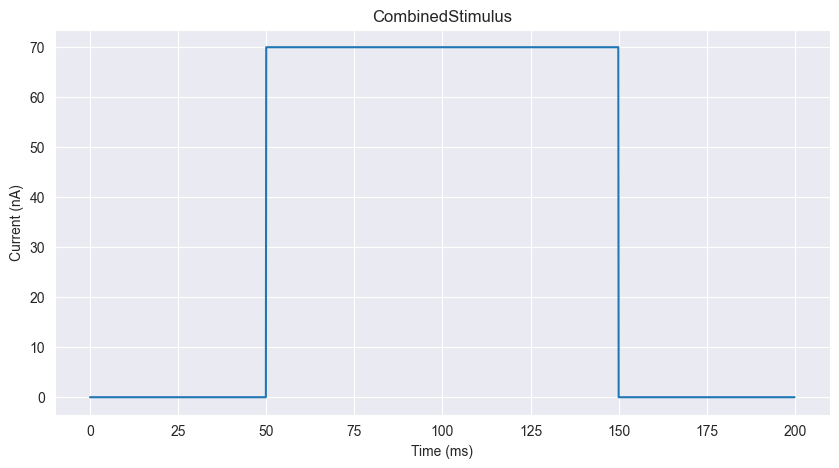

In [5]:
step.plot()

In [6]:
step.current.shape

(2000,)

### Ramp Stimulus

Or similarly for creating a ramp protocol.

In [7]:
ramp = stim_factory.ramp(pre_delay=70, duration=110, post_delay=70, amplitude=0.5)
ramp

CombinedStimulus(dt=0.1)

<Axes: title={'center': 'CombinedStimulus'}, xlabel='Time (ms)', ylabel='Current (nA)'>

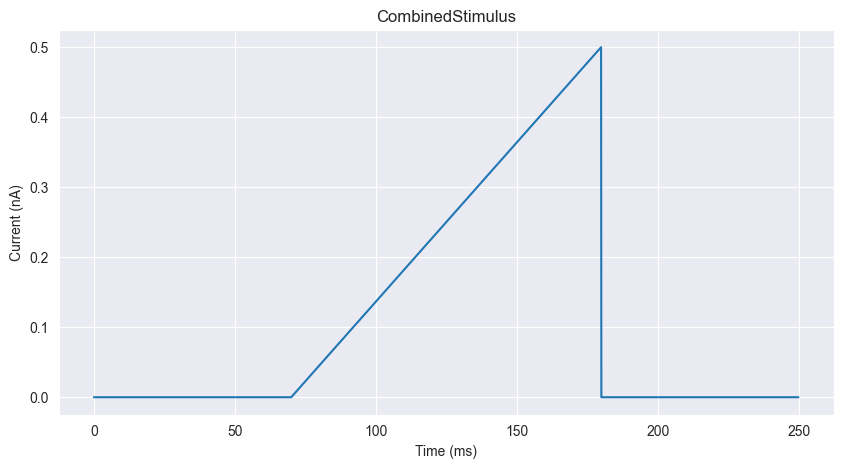

In [8]:
ramp.plot()

### APWaveform Stimulus

Here we will create an APWaveform Stimulus object which is a type of Step Stimulus.

In [9]:
apwaveform = stim_factory.ap_waveform(threshold_current=0.5)
apwaveform

CombinedStimulus(dt=0.1)

In [10]:
apwaveform.current.shape

(5500,)

In [11]:
apwaveform.time.shape

(5500,)

<Axes: title={'center': 'CombinedStimulus'}, xlabel='Time (ms)', ylabel='Current (nA)'>

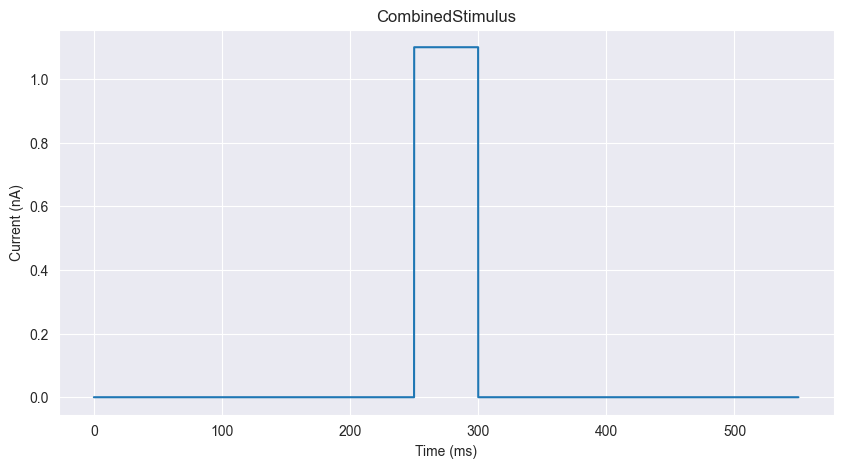

In [12]:
apwaveform.plot()

In [13]:
len(apwaveform)

5500

### Combining Stimuli

We can also combine multiple stimuli into a single stimulus. In fact APWaveform is a combined stimulus.


**Note:** The stimuli are combined in the order they are added.

In [14]:
stim2 = stim_factory.ramp(pre_delay=200, duration=250, post_delay=10, amplitude=0.5)
stim3 = stim_factory.step(amplitude=0.21, pre_delay=0, duration=150, post_delay=50)
stim4 = stim_factory.step( amplitude=0.0, pre_delay=0, duration=150, post_delay=50)

In [15]:
combined_stimulus = stim2 + stim4 + stim3 + stim2

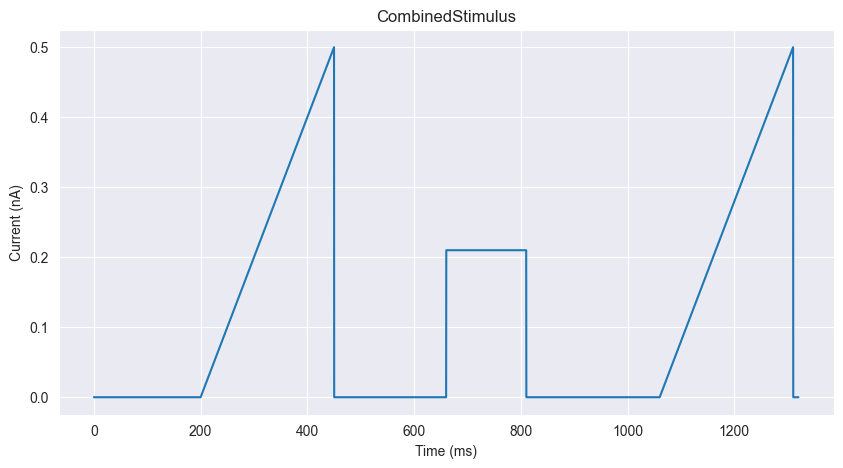

In [16]:
ax = combined_stimulus.plot()
ax.figure.set_size_inches(10, 5)

### Cheops Stimuli

Cheops stimuli are combined stimuli that consists of ramps in a sequence of 2D pyramid shapes.

`PosCheops` is a Cheops stimulus with positive amplitude peaks.
`NegCheops` is a Cheops stimulus with negative amplitude peaks.

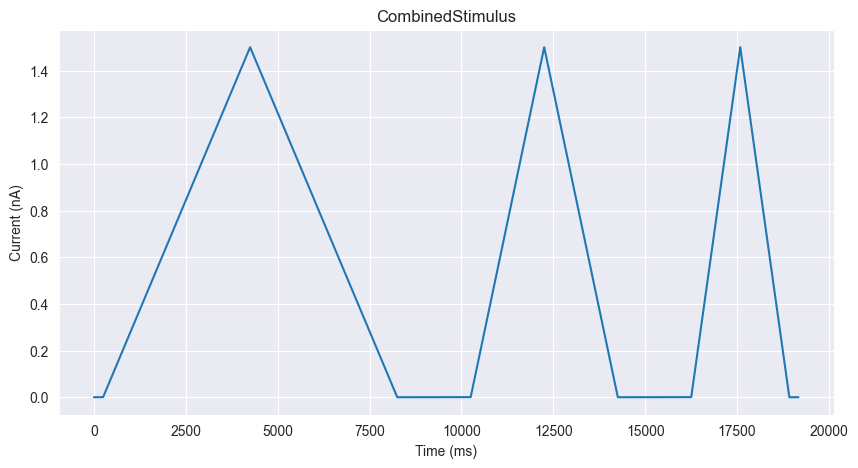

In [17]:
# PosCheops stimulus
pos_cheops = stim_factory.pos_cheops(threshold_current=0.5)
ax = pos_cheops.plot()

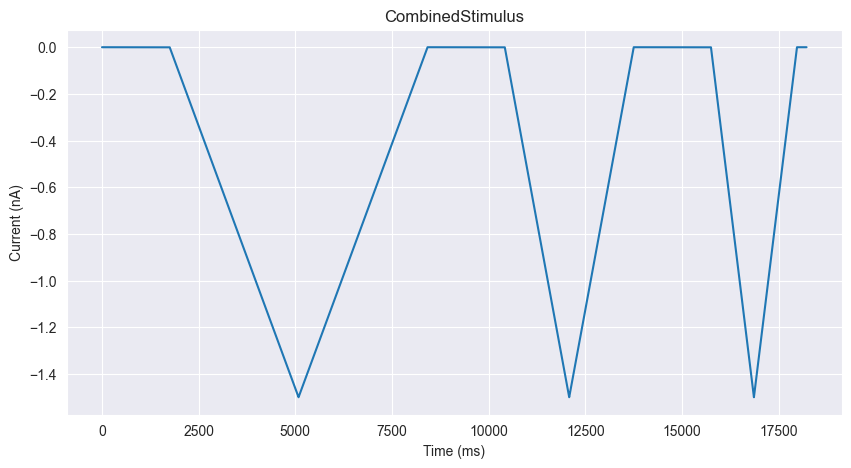

In [18]:
# NegCheops Stimulus
neg_cheops = stim_factory.neg_cheops(threshold_current=0.5)
ax = neg_cheops.plot()

### SineSpec Stimuli

SineSpec stimuli are a type of Zap stimulus, designed to generate a sinusoidal current input with a controlled amplitude.

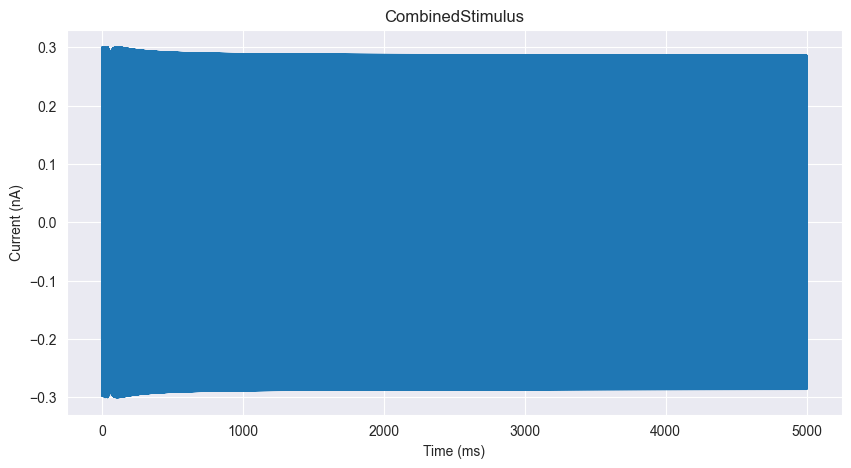

In [19]:
sinespec = stim_factory.sinespec(threshold_current=0.5)
ax = sinespec.plot()

To improve visibility, we zoom into the first 100 ms of the stimulus. This allows us to better observe the waveform details without excessive compression

(0.0, 100.0)

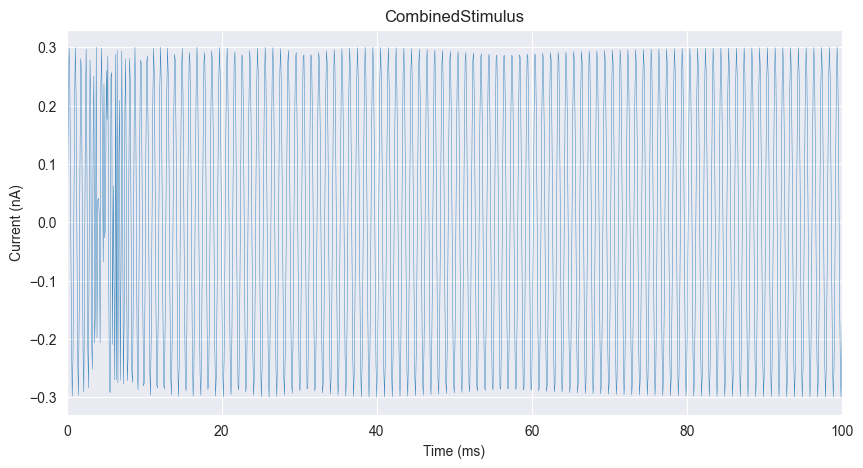

In [20]:
sinespec = stim_factory.sinespec(threshold_current=0.5)
ax = sinespec.plot(linewidth=0.3, markersize=1)
ax.set_xlim(0, 100)

### Ornstein-Uhlenbeck (OU) Stimuli

Ornstein-Uhlenbeck (OU) stimuli are a type of stochastic input designed to model synaptic noise and fluctuating conductance. This stimulus follows an OU process, which generates temporally correlated noise, mimicking the irregular activity seen in biological neurons.

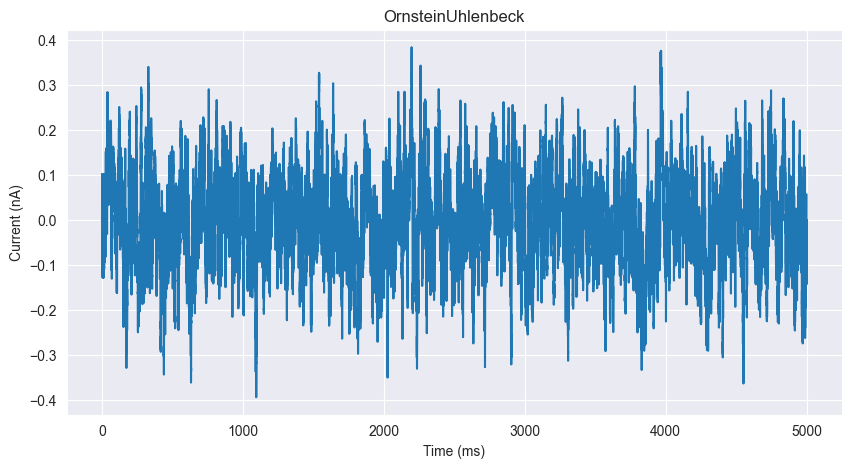

In [21]:
ou_stimulus = stim_factory.ornstein_uhlenbeck(
    duration=5000.0,  # 5 seconds
    tau=5.0,          # Time constant
    sigma=0.1,        # Standard deviation
    mean=0.0,         # Mean current
    seed=42,          # Random seed
)
ax = ou_stimulus.plot()

### Shot Noise Stimuli

Shot noise stimuli are a type of stochastic input that model discrete synaptic events occurring at irregular intervals. Unlike Ornstein-Uhlenbeck noise, which is temporally correlated, shot noise consists of random, instantaneous current pulses that approximate the effects of individual synaptic inputs.

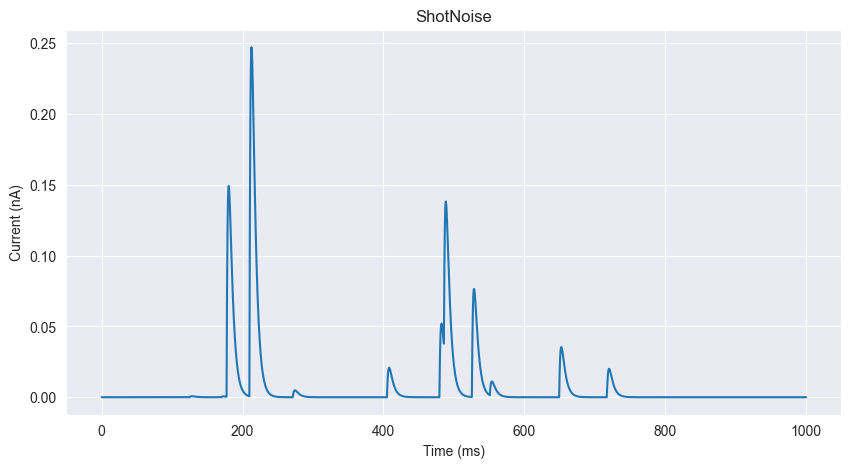

In [22]:
shot_noise_stimulus = stim_factory.shot_noise(
    duration=1000, rate=10, amp_mean=0.1, amp_var=0.02, rise_time=2, decay_time=5, seed=42
)
ax = shot_noise_stimulus.plot()

### Step Noise

Step noise is a type of stimulus where the injected current changes in discrete steps at fixed intervals, but the amplitude of each step is randomly sampled. This creates a signal that mimics fluctuating synaptic input while maintaining a structured stepwise behavior.

Unlike smooth noise processes (like Ornstein-Uhlenbeck), step noise introduces sudden changes in current at fixed time intervals. It is useful for simulating randomized perturbations in neural activity.

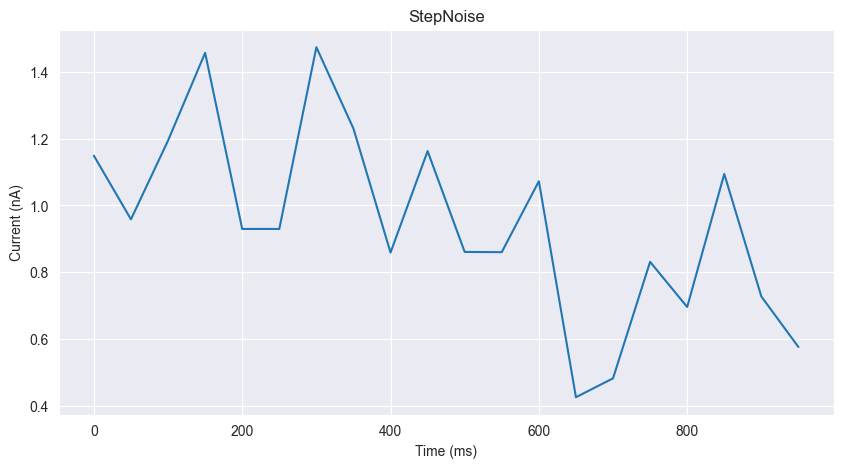

In [23]:
step_noise_stimulus = stim_factory.step_noise(
    duration=1000,       # 1000 ms total duration
    step_duration=50,    # Each step lasts 50 ms
    mean=1.0,            # Mean amplitude of 1.0
    variance=0.3,        # Variance in amplitude
    seed=42              # Reproducibility
)
ax = step_noise_stimulus.plot()

## Applying the Stimulus to the Neuron Model

Now let's apply the combined stimulus we created to a Neuron model and simulate.

### Creating the Cell (Neuron)

Next, we load a basic neuron model that we'll be using for our simulation.

In [24]:
# in another simulation inject the combined stimulus
cell = create_ball_stick()
cell.inject_current_waveform(t_content=combined_stimulus.time, i_content=combined_stimulus.current)
sim = Simulation(cell)
duration = 1500
print("Running the simulation...")
sim.run(duration, dt=0.1)
print("Done.")
time, voltage = cell.get_time(), cell.get_soma_voltage()

Running the simulation...
Done.


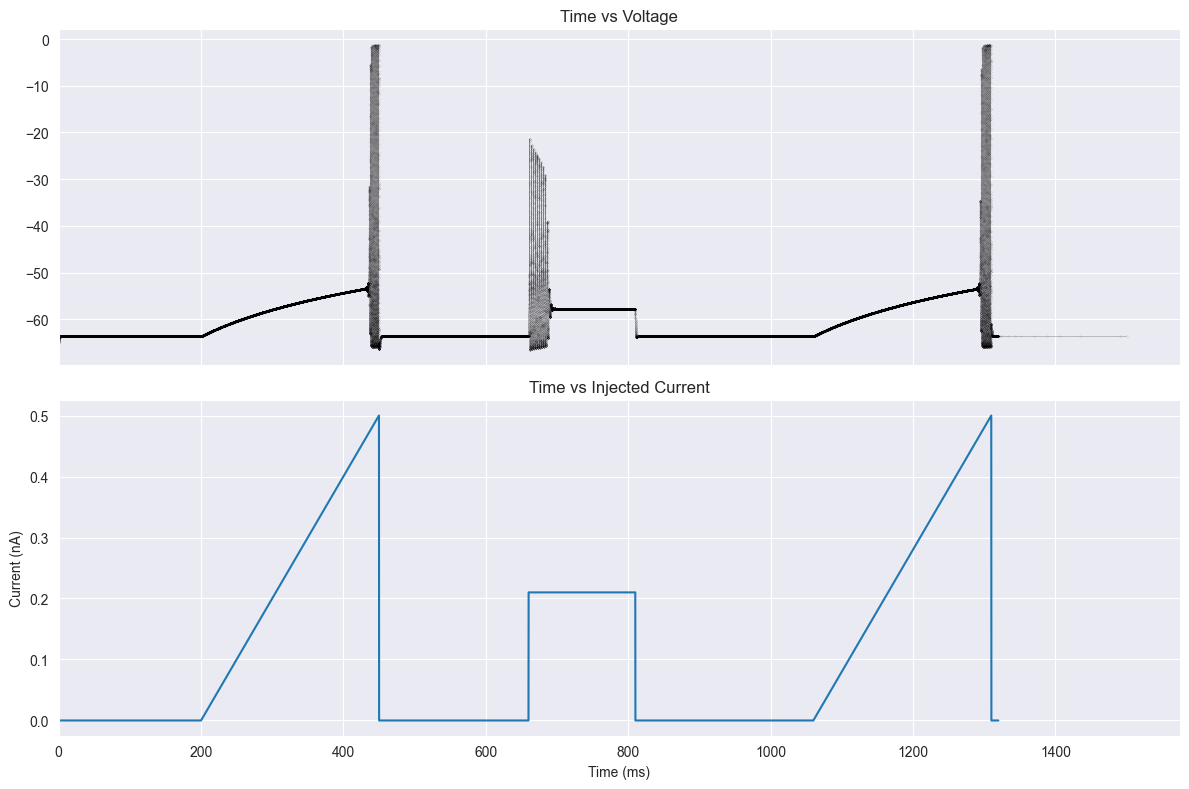

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)  # 2 rows, 1 column, wider figure, shared x-axis

# Plot voltage over time on the first subplot
axs[0].plot(time, voltage, marker='.', markersize=0.1, color='k', linewidth=0.15)
axs[0].set_title('Time vs Voltage')
axs[0].set_xlim(left=0)  # Make the plot start from 0 on the x-axis

# Plot injected current over time on the second subplot
axs[1] = combined_stimulus.plot(axs[1])
axs[1].set_title('Time vs Injected Current')
axs[1].set_xlim(left=0)  # Make the plot start from 0 on the x-axis

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.show()

In the plot above we see that the voltage activity start at the time we inject the stimulus and it lasts until the stimulus ends.

More information on the available stimuli can be found at the documentation: https://bluecellulab.readthedocs.io/en/latest/